## Групповой проект команды FlexML. Exploratory Data Analysis
 - Гуськова Мария
 - Мусин Олег
 - Сухотин Олег
 - Ванцов Иван

## Первичный анализ полученных данных
Проведем первичную очистку данных, полученных от Netflix.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [34]:
netflix_shows = pd.read_excel('assets/NetflixShows.xlsx')
netflix_shows.info() # для определения типа данных в колонках, анализа возможных пропусков
netflix_shows["ratingDescription"].sort_values() # для определения диапазона значений колонки
ns_cleared = netflix_shows.drop_duplicates() # для удаление дубликатов
ns_cleared = ns_cleared.drop('ratingLevel', axis=1) # удаляем колонку ratingLevel, ratingDescription, axis=1 = означает колонки (0 - строки)
ns_cleared = ns_cleared.drop('ratingDescription', axis=1)

ns_cleared.head
ns_cleared.isna().sum() # посчитаем, сколько значений nan, чтобы убедиться, что они только в колонке user rating score


# переименования для удобства
# ratingLevel -> age_rating
# release year -> release_year
# user rating score -> score
# user rating size -> size
ns_cleared = ns_cleared.rename(columns={'rating': 'age_rating'})
ns_cleared = ns_cleared.rename(columns={'release year': 'release_year'})
ns_cleared = ns_cleared.rename(columns={'user rating score': 'score'})
ns_cleared = ns_cleared.rename(columns={'user rating size': 'size'})
ns_cleared.describe() # проанализируем данные в таблице в общем виде

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1000 non-null   object 
 1   rating             1000 non-null   object 
 2   ratingLevel        941 non-null    object 
 3   ratingDescription  1000 non-null   int64  
 4   release year       1000 non-null   int64  
 5   user rating score  605 non-null    float64
 6   user rating size   1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


,release_year,score,size
count,500.000000,256.000000,500.000000
mean,2010.976000,81.398438,80.972000
std,7.829305,12.730904,0.998604
min,1940.000000,55.000000,80.000000
25%,2009.000000,71.000000,80.000000
50%,2014.000000,83.500000,80.000000
75%,2016.000000,93.000000,82.000000
max,2017.000000,99.000000,82.000000


1000 записей всего.
Разберем колонки нашего датасета и предложим спектр проблем или особенностей
| Колонка           | Текущий тип | Комментарий                                                                                                                               |
| ----------------- | ----------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| title             | object      | Любая последовательность букв на латинице и цифр (есть пример - "3%"). Есть риск дубликатов по неполному совпадению, требуется проверить. |
| rating            | object      | Код категории, пропусков нет                                                                                                              |
| ratingLevel       | object      | Описаниние категории, может отсутствовать. Дополнительного смысла, отличного от ragingLevel, не несет.                                    |
| ratingDescription | int64       | Закодированное значение рейтинга. Диапазон значений: от 10 до 124. Способ формирования - неизвестен                                       |
| release year      | int64       | Год выпуска, пропусков нет.                                                                                                               |
| user rating score | float64     | Числовое значение рейтинга. Может отсутствовать, вместо пропусков - NA (244 пропуска)                                                     |
| user rating size  | int64       | Общий рейтинг пользователей. Пропусков или не-числовых значений - нет.                                                                    |




EDA
 - удаление колонки ratingLevel, как не несущей дополнительного смысла
 - удаление дубликатов. В исходной таблице 500 полных дублей.
 - что у нас в таблице - фильмы и/или сериалы?
 - анализ "похожести" названий - сколько дублей по этому признаку?
 

Результаты "очищенного" датасета, первые выводы:
 - данные по 500 уникальным шоу
 - данные по шоу с 1940 по 2017 год. Больше всего данных по шоу с 2014 года

Далее повышаем детализацию первичного анализа и ищем более интересные признаки.


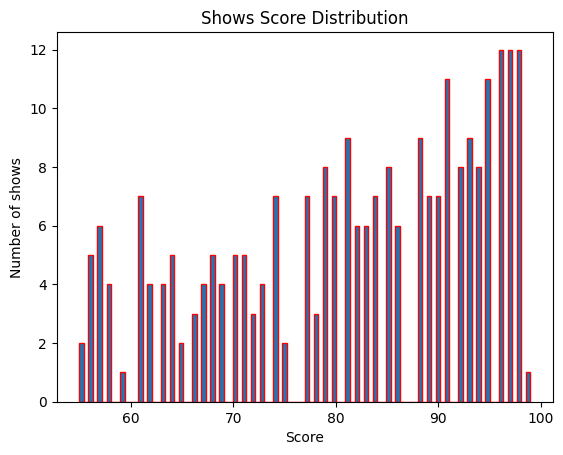

In [47]:
# построим гистограмму распределения user rating score
plt.hist(ns_cleared['score'], bins = 100, edgecolor = 'r')
plt.xlabel('Score')
plt.ylabel('Number of shows')
plt.title('Shows Score Distribution')

plt.savefig("assets/output/user_rating_score.png", dpi=300)


На основании гистограммы, видно что кол-во шоу с рейтингом выше 80 больше, чем обратных

In [ ]:
# построим гистограмму распределения user rating size
plt.hist(ns_cleared['size'], bins = 100, edgecolor = 'r')
plt.xlabel('Size')
plt.ylabel('Number of score size')
plt.title('Shows Score Size Distribution')

plt.savefig("assets/output/user_rating_size.png", dpi=300)

На основании гистограммы видно, что существует всего 3 типа score_size (80, 81, 82). Со слова Ю. Сночкина эти данные нам не нужны и не имеют смысла.

In [ ]:
# Посмотрим, как оценки на фильмы менялись во времени
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='score', data=ns_cleared, marker='o', color='r')
plt.title('Score Change Over Release year', fontsize=16)
plt.xlabel('Release year', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.savefig("assets/output/score_change_over_release_year.png", dpi=300)

plt.show()

In [ ]:
# Посмотрим, как категории фильмов менялись во времени. Посчитаем количества всех категорий по годам

In [ ]:
# Количество шоу имеющих оценки по возрастным рейтингам

# Удаляем строки с NaN
ns_cleared.dropna(subset=['score'], inplace=True)  

# Проверка на наличие некорректных данных
if ns_cleared[['score']].isnull().values.any():
    print("В данных остались некорректные значения")

rating_counts = ns_cleared['age_rating'].value_counts()

# Построение гистограммы
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")

# Добавление подписей
plt.title('Количество фильмов по возрастным рейтингам')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Количество фильмов')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение значений на столбцах
for i, value in enumerate(rating_counts.values):
    plt.text(i, value + 2, str(value), ha='center', fontsize=10)

plt.savefig("assets/output/number_of_shows_of_each_age_rating.png", dpi=300)

plt.show()

In [ ]:
# Посмотрим на корреляцию оценок и возрастного рейтинга шоу

# Подсчет количества фильмов по возрастным рейтингам
age_rating_counts = ns_cleared['age_rating'].value_counts().reset_index()
age_rating_counts.columns = ['age_rating', 'count']

# Рассчет средней оценки по возрастным рейтингам
age_rating_avg = ns_cleared.groupby('age_rating')['score'].mean().reset_index()

# Объединение данных
age_rating_avg = age_rating_avg.merge(age_rating_counts, on='age_rating')

# Сортировка по количеству фильмов
age_rating_avg = age_rating_avg.sort_values(by='count', ascending=False)

# Построение гистограммы
plt.figure(figsize=(8, 5))
sns.barplot(x='age_rating', y='score', data=age_rating_avg, palette="coolwarm")

# Добавление подписей к столбцам
for i, value in enumerate(age_rating_avg['score']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', fontsize=10)

# Оформление графика
plt.title('Средняя оценка по возрастным рейтингам')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Средняя оценка')
plt.ylim(0, 100)  # Диапазон оценок от 0 до 100
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("assets/output/average_shows_score_over_age_rating.png", dpi=300)

plt.show()